Software has played a big role in digital holographic imaging, arguably starting from the publication in which [Goodman and Lawrence generated images from electronically recorded holograms](http://aip.scitation.org/doi/10.1063/1.1755043). One of the things I would like to do for my [lensless imager project](https://hackaday.io/kmdouglass) is to develop a small set of tools to simulate various types of digital holograms. My reason for wanting to do this is that it will help in developing the algorithms that will actually perform the reconstructions from real holograms. In this post, I will explore a simple method for simulating holograms that is explained in an excellent publication I recently found: [Tatiana Latychevskaia and Hans-Werner Fink, " Practical algorithms for simulation and reconstruction of digital in-line holograms," arXiv 1412.3674 (2016)](https://arxiv.org/abs/1412.3674).

# Inline holography with plane waves

## Create the ground truth

The first step in the simulation of a digital hologram is to create a ground truth object, i.e. a an object whose optical properties we know *a priori*. Rather than try to infer an object from a hologram--which is what the lensless imager should do--the simulations should work in the opposite sense and create a realistic hologram from the ground truth. Later, we can use the simulated holograms to test different reconstruction algorithms and see which ones come closest to reproducing the known objects.

In [1]:
%pylab inline
from numpy.fft import fft2, fftshift, ifftshift
import scipy
from scipy.integrate import simps
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis' 

print('Python version:\n{}\n'.format(sys.version))
print('Numpy version:\t\t{}'.format(np.__version__))
print('matplotlib version:\t{}'.format(matplotlib.__version__))
print('Scipy version:\t\t{}'.format(scipy.__version__))

Populating the interactive namespace from numpy and matplotlib
Python version:
3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

Numpy version:		1.11.3
matplotlib version:	2.0.0
Scipy version:		0.19.0


For the first simulation, I will start by making a relatively simple object: a non-absorbing circle with a constant phase. In holography, objects are represented by a position-dependent amplitude and phase. The amplitude determines how much the object absorbs the incident light and the phase determines by how much the light inside the object is slowed-down relative to the light that passes outside the object.

To create a non-absorbing circle, I create a square array of pixels whose values are all equal to one. What's neat about this is that this array already represents what is perhaps the simplest object to simulate: nothing at all! If every pixel is equal to one, it means that the light is neither being absorbed nor slowed down anywhere.

Of course, we want to eventually look at microscopic objects like cells, so we create a simple cell by making a circular mask and adjust the phase of all the pixels inside the mask relative to those outside it.

In [2]:
numPixels = 512
gtRadius  = 50 # ground truth radius, pixels
gtPhase   = 0.75 # radians
gtCenter  = numPixels / 2 # assumes numPixels is even
W, H      = np.meshgrid(np.arange(0, numPixels), np.arange(0, numPixels)) # coordinates of the array indexes
gtMask    = np.sqrt((W - gtCenter)**2 + (H - gtCenter)**2) <= gtRadius # boundaries of the object

gt = np.ones((numPixels, numPixels), dtype=np.complex)
gt[gtMask] = np.exp(1j * gtPhase)

The last line of the code above, `gt[gtMask] = np.exp(1j * gtPhase)`, sets all the values in the `gt` array that are inside the circular mask to the complex phasor \\( \exp \left( j \phi \right) \\), where \\( \phi \\) is the value of the phase imparted onto the light by the object. For real objects, this phase would be equal to the optical path length of the object, which is the product of the object's refractive index by its real size.

Let's now go ahead and visualize the object to make sure we created it correctly.

In [3]:
def plot_complex_field(field, vmin=0, vmax=1):
    fig, ax = plt.subplots(nrows=1, ncols=2)
    
    amp   = ax[0].imshow(np.abs(field))
    phase = ax[1].imshow(np.angle(field), vmin=0, vmax = 2*np.pi)

    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Amplitude')

    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb_amp = plt.colorbar(amp, cax=cax)

    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Phase')

    divider = make_axes_locatable(ax[1])
    cax  = divider.append_axes("right", size="5%", pad=0.05)
    cb_phase  = plt.colorbar(phase, cax=cax)
    cb_phase.set_ticks([0, 2*np.pi])
    cb_phase.set_ticklabels(['0', r'2$\pi$'])

    return fig, ax, amp, phase, cb_amp, cb_phase

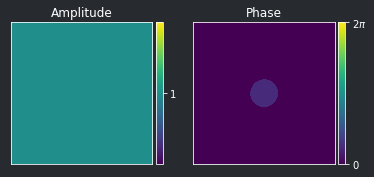

In [4]:
_, _, _, _, cb_amp, _ = plot_complex_field(gt)
cb_amp.set_ticks([1])
plt.show()

As you can see, the amplitude remains equal to 1 everywhere, which is what we would expect for a non-absorbing object. In the plot of the phase you can see the faint circle at the center of the image. I plotted the phase on a scale of \\( \left[ 0, 2 \pi \right] \\) for two reasons:

1. to emphasize that the object only weakly perturbs the light;
2. because one complete rotation of the phasor in the complex plane is \\(2 \pi \\) radians. Any value outside the range \\( \left[ 0, 2 \pi \right] \\) can be mapped back onto a value in this range.

### Set the physical dimensions

The final step in the object creation is to set up the physical dimensions of the problem. There are a few ways we can do this, but I typically like to set the number of pixels that sample the object and the pixel size independently. Then, the physical radius of the object is equivalent to `gtRadius * pixelSize` and the total array size is equal to `numPixels * pixelSize`. What's more, because the array is square, we can create just one coordinate vector for both directions.

In [5]:
pixelSize = 0.1 # microns
x = np.linspace(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, num = numPixels, endpoint = True)

physicalRadius = gtRadius * pixelSize
print('The physical radius is:  {} microns'.format(physicalRadius))

The physical radius is:  5.0 microns


The computational tool that I will use to propagate the wave fronts is known as the angular spectrum propagator. This tool requires two Fourier transforms and therefore requires that I setup the arrays that denote the spatial frequencies as well. As I discussed in a [previous post](http://kmdouglass.github.io/posts/simple-pupil-function-calculations.html), this can be done like so:

In [6]:
dx = x[1] - x[0]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = np.arange(-fS / 2, fS / 2, step = df) # Spatial frequency, inverse microns

`dx` is the sampling period in the object space, whose inverse `fS` is the sampling frequency. The maximum information content in the object's Fourier transform is found at the Nyquist frequency, or `fS / 2`.

## Compute the hologram

Two common ways to generate a hologram in a real experiment are to illuminate the object with a plane wave and with a spherical wave. In this simulation, I will assume a plane wave illumination because this is somewhat simpler and an easy first case to deal with.

### Step 1: Find the Fourier transform of the object

According to the publication by [Latychevskaia and Fink](https://arxiv.org/abs/1412.3674), we first need to compute the Fourier transform of the object.

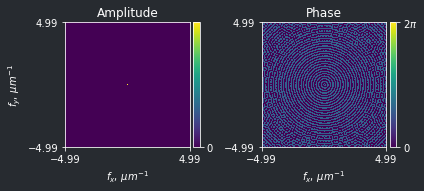

In [7]:
GT = ifftshift(fft2(fftshift(gt))) * dx**2
fig, ax, amp, phase, cb_amp, _ = plot_complex_field(GT)

amp.set_extent([fx[0], fx[-1], fx[0], fx[-1]])
ax[0].set_xticks([-fS / 2, fS / 2])
ax[0].set_yticks([-fS / 2, fS / 2])
ax[0].set_xlabel(r'$f_{x}, \, \mu m^{-1}$')
ax[0].set_ylabel(r'$f_{y}, \, \mu m^{-1}$')
cb_amp.set_ticks([0, 2612]) # I think that there's a bug in matplotlib 2.0 preventing correct tick displays

phase.set_extent([fx[0], fx[-1], fx[0], fx[-1]])
ax[1].set_xticks([-fS / 2, fS / 2])
ax[1].set_yticks([-fS / 2, fS / 2])
ax[1].set_xlabel(r'$f_{x}, \, \mu m^{-1}$')

plt.tight_layout()
plt.show()

We cannot really see much in the amplitude plot, so let's put it on a log-scale.

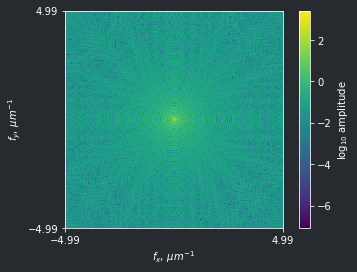

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1)

img = ax.imshow(np.log10(np.abs(GT)), extent=[fx[0], fx[-1], fx[0], fx[-1]])
cb  = plt.colorbar(img)
cb.set_label('$\log_{10}$ amplitude')

ax.set_xticks([-fS / 2, fS / 2])
ax.set_yticks([-fS / 2, fS / 2])
ax.set_xlabel(r'$f_{x}, \, \mu m^{-1}$')
ax.set_ylabel(r'$f_{y}, \, \mu m^{-1}$')

plt.show()

### Step 2: Verify that the Fourier transform is correct

We can verify that we did everything correctly by computing the discrete integral of the absolute squares of the field passing through the original object and its Fourier transform. By [Parseval's theorem](https://en.wikipedia.org/wiki/Parseval's_theorem), these should be equivalent. Though it may seem a bit mysterious, Parseval's theorem is just restating the well-known law about the conservation of energy. Simply put, the energy in the field passing through the object should be equal to the energy carried by its Fourier transform.

In [9]:
gt_int = simps(simps(np.abs(gt)**2, dx=dx), dx=dx)
GT_int = simps(simps(np.abs(GT)**2, dx=df), dx=df)
print('Integral, object: {:.4f}'.format(gt_int))
print('Integral, Fourier transform of object: {:.4f}'.format(GT_int))

Integral, object: 2621.4400
Integral, Fourier transform of object: 2631.7081


Notice that there's an error here between the sum of squares of the object and its Fourier transform. In this case, the percent error is:

In [10]:
error = np.abs(gt_int - GT_int) / gt_int * 100
print('Percent error: {:.2f}%'.format(error))

Percent error: 0.39%


The error is not large, but it does make you wonder where exactly it comes from. Let's do one more sanity check before going any farther. Another property of Fourier transforms is that the DC component (the value of the Fourier transform at a frequency of zero) should be equal to the average of the original signal.

The average of a two-dimensional discrete signal whose samples are equally spaced is expressed as

\begin{equation*}
\bar{f} = \frac{1}{XY}\sum_{i=0}^{M-1}\sum_{j=0}^{N-1} f \left( i, j \right) \Delta x \Delta y
\end{equation*}

Here, \\( X \\) and \\( Y \\) are the physical lengths of the array representing the signal and \\( \Delta x \\) and \\( \Delta y \\) are the spacings between each array element. Furthermore, the array has a number of pixels \\( M \\) and \\( N \\) in the \\( x \\) and \\( y \\) directions, respectively. In our case the arrays are square and equally sampled in both directions, so \\( X = Y \\) and \\( \Delta X = \Delta Y \\). Additionally, the number of pixels is just \\( M = \frac{X}{\Delta X} \\), which means that the above expression may be simplified to

\begin{equation*}
\bar{f} = \frac{1}{M^2}\sum_{i=0}^{M-1}\sum_{j=0}^{M-1} f \left( i, j \right)
\end{equation*}

In [11]:
# Compute the average of the original object
gt_avg = np.sum(gt) * dx**2 / (x[-1] - x[0])**2
print('Average of the object field: {:.4f}'.format(gt_avg))

Average of the object field: 0.9959+0.0205j


As for the DC term, we need to extract the zero-frequency value which lies at the center of the `GT` array. There is one caveat here: **the values in the arrays are densities**. We therefore need to multiply by the area of the pixel in the array's center, which is simply `df**2`.

In [12]:
dc_term = GT[numPixels // 2, numPixels // 2] * df**2
print('DC term: {:.4f}'.format(dc_term))

DC term: 0.9920+0.0204j


As you can see, there is also a slight difference between the average of the input field and the DC term of the input's Fourier transform. Since both sanity checks are relatively close, however, I suspect that the differences are due to numerical rounding errors.

### Step 3: Create the angular spectrum propagator

The reason we computed the Fourier transform of the object was to determine its angular spectrum, i.e. the array of plane waves traveling at different directions to the axis that coherently combine to form the object. Computing the field at another axial plane means advancing the phase of each of these plane waves by an amount that depends on the wavelength of the light and the angle at which the plane wave is traveling relative to the optical axis. We can do this by multiplying the Fourier transform of the object by what's known as the **transfer function of free space**:

\begin{equation*}
H \left( f_x, f_y; z \right) = \exp \left[ j \frac{2 \pi z}{\lambda } \sqrt{ 1 - \left( \lambda f_x \right)^2 - \left( \lambda f_y \right)^2 } \right]
\end{equation*}

\\( z \\) is a free parameter and is the distance from the object plane in which we wish to compute the field. To get the field from the object in a plane \\( z \\), we multiply the Fourier transform of the field by this transfer function and then compute the inverse Fourier transform of the product. This is essentially the operation I performed in a [previous post where I computed the defocused image of an isotropic point emitter in a microscope](http://kmdouglass.github.io/posts/simulating-microscope-pupil-functions.html).

Here's what the phase angle the transfer function looks like for propagation over \\( 10 \, \mu m \\):

/home/kmdouglass/anaconda3/envs/nikola/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


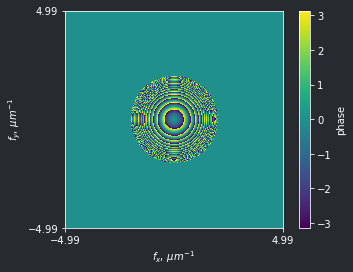

In [13]:
def H(fx, fy, z, wavelength=0.5):
    square_root = np.sqrt(1 - (wavelength**2 * fx**2) - (wavelength**2 * fy**2))
    temp = exp(1j * 2 * np.pi * z / wavelength * square_root)
    temp[np.isnan(temp)] = 0 # replace nan's with zeros
    return temp

FX, FY = np.meshgrid(fx, fx)
fig, ax = plt.subplots(nrows=1, ncols=1)
img = ax.imshow(np.angle(H(FX, FY, 10)))
img.set_extent([fx[0], fx[-1], fx[0], fx[-1]])

cb  = plt.colorbar(img)
cb.set_label('phase')

ax.set_xticks([-fS / 2, fS / 2])
ax.set_yticks([-fS / 2, fS / 2])
ax.set_xlabel(r'$f_{x}, \, \mu m^{-1}$')
ax.set_ylabel(r'$f_{y}, \, \mu m^{-1}$')
plt.show()

And the amplitude:

/home/kmdouglass/anaconda3/envs/nikola/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


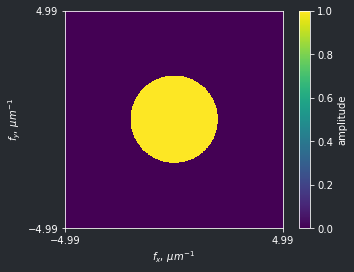

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
img = ax.imshow(np.abs(H(FX, FY, 10)))
img.set_extent([fx[0], fx[-1], fx[0], fx[-1]])

cb  = plt.colorbar(img)
cb.set_label('amplitude')

ax.set_xticks([-fS / 2, fS / 2])
ax.set_yticks([-fS / 2, fS / 2])
ax.set_xlabel(r'$f_{x}, \, \mu m^{-1}$')
ax.set_ylabel(r'$f_{y}, \, \mu m^{-1}$')
plt.show()

You can see right away that the transfer function appears circular. The reason for this is that the argument inside the square root becomes negative for large spatial frequencies, which makes the whole transfer function in this region into a decaying exponential. These spatial frequencies correspond to plane waves that exponentially decay as they propagate away from the sample; they are so-called "evanescent" waves.

For distances much larger than a wavelength of light, the amplitude of the transfer function in this area is effectively zero. 

### Step 4: Propagate the field and create the hologram

Let's now compute the field in the new plane at some distance from the sample. We do this by multiplying the Fourier transform of the ground truth by the transfer function and computing this product's inverse Fourier transform.

/home/kmdouglass/anaconda3/envs/nikola/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


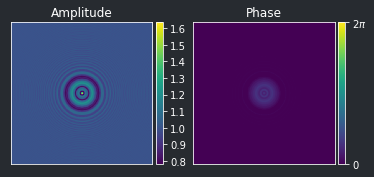

In [15]:
distance = 10 # microns
gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, distance)))) / dx**2
_, _, _, _, cb_amp, _ = plot_complex_field(gt_prime)
plt.show()

In [16]:
# Check again for conservation of energy
gt_int       = simps(simps(np.abs(gt)**2, dx=dx), dx=dx)
GT_int       = simps(simps(np.abs(GT)**2, dx=df), dx=df)
gt_prime_int = simps(simps(np.abs(gt_prime)**2, dx=dx), dx=dx)
print('Integral, object: {:.4f}'.format(gt_int))
print('Integral, Fourier transform of object: {:.4f}'.format(GT_int))
print('Integral, hologram plane: {:.4f}'.format(gt_prime_int))

Integral, object: 2621.4400
Integral, Fourier transform of object: 2631.7081
Integral, hologram plane: 2621.0387


Because our hologram will be recorded with a normal camera that is insensitiveto to the phase of the light, we take the absolute square to obtain the final simulated image of the hologram.

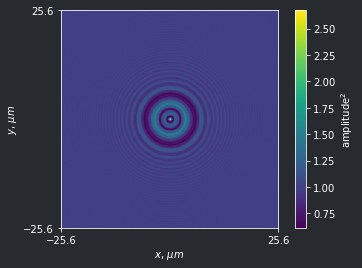

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1)
img = ax.imshow(np.abs(gt_prime)**2)
img.set_extent([x[0], x[-1], x[0], x[-1]])

cb  = plt.colorbar(img)
cb.set_label('amplitude$^2$')

ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')
ax.set_ylabel(r'$y, \, \mu m$')
plt.show()

# Movie of propagating hologram

Here I've made a movie of the hologram propagating along the axial direction between \\(z = 0 \, \mu m \\) and \\(z = 100 \, \mu m \\).

In [18]:
from matplotlib import animation

In [19]:
numPoints = 1001
z         = np.linspace(0, 100, num = numPoints)

fig, ax    = plt.subplots(nrows=1, ncols=1)
vmin, vmax = 0, 3

img = ax.imshow(np.abs(gt_prime)**2, vmin=vmin, vmax=vmax)
img.set_extent([x[0], x[-1], x[0], x[-1]])
ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')

cb  = plt.colorbar(img)
cb.set_label('amplitude$^2$')
cb.set_clim([vmin, vmax])

txt = ax.text(10, 20, 'z = {:.1f} $\mu m$'.format(distance))

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((numPixels, numPixels)))
    return img,

# This function is called for each frame of the animation
def animate(frame):
    gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, z[frame])))) / dx**2
    hologram = np.abs(gt_prime)**2
    
    img.set_data(hologram)
    img.set_extent([x[0], x[-1], x[0], x[-1]])

    txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return img,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=numPoints,
                               init_func=init, interval=20, blit=True)

# Save the animation
myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('propagating_hologram.mp4', writer = myWriter)
    
plt.close()

/home/kmdouglass/anaconda3/envs/nikola/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


<video controls src="../propagating_hologram.mp4" type="video/mp4" />

# Interactively propagate the hologram

Below I've used Jupyter's interactive plotting features to allow me to scan through the axial direction and observe how the hologram changes as a function of distance from the sample.

**To use this feature, you will need to download this notebook and run it on your own a Jupyter notebook server.**

<IPython.core.display.Javascript object>


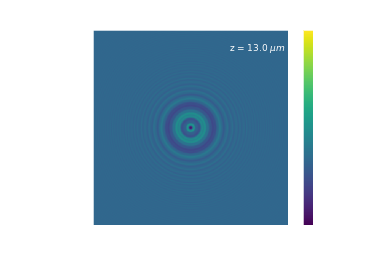

In [22]:
from ipywidgets import interact, FloatSlider
# Change to interactive mode
# This must be run in a Jupyter notebook!
%matplotlib nbagg

fig, ax = plt.subplots(nrows=1, ncols=1)
vmin, vmax = 0, 3
img = ax.imshow(np.abs(gt_prime)**2, vmin=vmin, vmax=vmax)
img.set_extent([x[0], x[-1], x[0], x[-1]])

ax.set_xticks([x[0], x[-1]])
ax.set_yticks([x[0], x[-1]])
ax.set_xlabel(r'$x, \, \mu m$')

cb  = plt.colorbar(img)
cb.set_label('amplitude$^2$')
cb.set_clim([vmin, vmax])

txt = ax.text(10, 20, 'z = {:.1f} $\mu m$'.format(distance))

plt.show()

def compute_hologram(z):
    gt_prime = fftshift(ifft2(ifftshift(GT * H(FX, FY, z)))) / dx**2
    hologram = np.abs(gt_prime)**2
    
    img = ax.imshow(hologram, vmin=vmin, vmax=vmax)
    img.set_extent([x[0], x[-1], x[0], x[-1]])

    txt.set_text('z = {:.1f} $\mu m$'.format(z))   

In [23]:
interact(compute_hologram, z=FloatSlider(min=0,max=50,step=1,value=1))
plt.show()

/home/kmdouglass/anaconda3/envs/nikola/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


# Summary

Simulating an inline hologram with plane wave illumination requires a few steps: generating a ground-truth object, computing its angular spectrum, and propagating this spectrum to a new axial plane using the transfer function of free space. Two Fourier transforms are required: one for finding the object's angular spectrum and the other to convert the propagated spectrum back to real space.

If you have spherical wave illumination rather than plane wave illumination, then you will need to use the Fresnel propagator. This will make for a later discussion.